## **Sistema de Reconocimiento de Emociones Faciales (FER2013) Optimizado**
**Emerson Bautista - 2200078**

Este proyecto desarrolla un sistema de aprendizaje profundo para clasificar emociones faciales a partir de imágenes, utilizando el conocido dataset FER2013. El proceso abarca desde la preparación y el análisis de los datos hasta la construcción, entrenamiento y evaluación de un modelo de Red Neuronal Convolucional (CNN).

En resumen, es un sistema completo de reconocimiento de emociones faciales que incluye:

  - Carga eficiente del dataset desde Google Drive al entorno local de Colab

  - Análisis exploratorio de la distribución de clases

  - Preprocesamiento y aumento de datos para mejorar la generalización

  - Arquitectura CNN profunda con técnicas de regularización

  - Entrenamiento optimizado con callbacks avanzados

  - Evaluación exhaustiva del modelo

  - Interfaz interactiva para pruebas con imágenes propias

La interfaz final permite realizar múltiples pruebas consecutivas para evaluar el rendimiento del modelo con diferentes imágenes, haciendo del sistema una herramienta práctica para el reconocimiento de emociones faciales.

### **Importación de Librerías y Configuración del Entorno**

Esta celda inicial se encarga de preparar el entorno de trabajo. Se importan todas las librerías esenciales para el proyecto. **TensorFlow** y su API de alto nivel **Keras** son el núcleo para construir y entrenar el modelo de red neuronal. **NumPy** se utiliza para operaciones numéricas eficientes, especialmente con los arreglos de imágenes. **Matplotlib** es fundamental para la visualización de datos, como las gráficas de entrenamiento y las imágenes de muestra. **OpenCV (`cv2`)** se emplea para tareas de preprocesamiento de imágenes personalizadas. Finalmente, se importan módulos de **Google Colab** para interactuar con el sistema de archivos y montar Google Drive.


In [1]:
# --- Explicación: Importación de librerías ---
# Se importan las herramientas necesarias para el proyecto.
# os: Para interactuar con el sistema operativo (manejar archivos y directorios).
# numpy: Para cálculos numéricos y manipulación de arreglos (imágenes).
# matplotlib.pyplot: Para crear visualizaciones y gráficos.
# cv2 (OpenCV): Para procesamiento de imágenes, como leer y redimensionar.
# google.colab: Para montar Google Drive y manejar subida/bajada de archivos.
# tensorflow y keras: Para construir, entrenar y evaluar el modelo de Deep Learning.

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive, files
from IPython.display import display, HTML

# Se importan los componentes específicos de TensorFlow y Keras.
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Se aplica un estilo visual a los gráficos de Matplotlib para una mejor presentación.
plt.style.use('ggplot')
# Se asegura que los gráficos se muestren directamente en el notebook.
%matplotlib inline

print("✅ Todas las librerías han sido importadas correctamente.")
print(f"Versión de TensorFlow utilizada: {tf.__version__}")

✅ Todas las librerías han sido importadas correctamente.
Versión de TensorFlow utilizada: 2.19.0


### **Montaje de Google Drive y Copia del Dataset**

Para que el entrenamiento sea eficiente, el acceso a los datos debe ser lo más rápido posible. Leer miles de imágenes directamente desde Google Drive puede ser muy lento y crear un cuello de botella. Esta celda implementa una optimización crucial: primero, monta la unidad de Google Drive para acceder a los archivos y, segundo, **copia todo el dataset FER2013 desde Drive al almacenamiento local de la máquina virtual de Colab**. Este proceso, aunque toma un momento al inicio, acelera drásticamente la lectura de imágenes durante el entrenamiento, reduciendo significativamente los tiempos por época.

In [2]:
# --- Explicación: Conexión con Google Drive y copia de datos ---
# Se monta la unidad de Google Drive en el entorno de Colab.
# Esto permite acceder a los archivos almacenados en la nube.
drive.mount('/content/drive')

# --- Optimización de Rendimiento ---
# Se copian los datos desde Google Drive al disco local de Colab.
# Leer archivos desde el entorno local es mucho más rápido que desde Drive,
# lo que acelera significativamente el proceso de entrenamiento.

# Se define la ruta de origen en Drive y el destino local.
source_path = "/content/drive/MyDrive/Colab Notebooks/PROYECTO_FER_2013/FER2013"
destination_path = "/content/FER2013"

print("⌛ Copiando el dataset desde Google Drive al entorno local de Colab...")

# Se elimina cualquier copia previa para asegurar una copia limpia.
!rm -rf "{destination_path}"
# Se ejecuta el comando de copiado recursivo.
!cp -r "{source_path}" "{destination_path}"

print("✅ Copia del dataset completada.")

# Se definen las rutas a los directorios de entrenamiento y prueba en la copia local.
train_dir = os.path.join(destination_path, 'train')
test_dir = os.path.join(destination_path, 'test')

# Se verifica que los directorios existen para evitar errores posteriores.
print(f"Directorio de entrenamiento existe: {os.path.exists(train_dir)}")
print(f"Directorio de prueba existe: {os.path.exists(test_dir)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⌛ Copiando el dataset desde Google Drive al entorno local de Colab...
✅ Copia del dataset completada.
Directorio de entrenamiento existe: True
Directorio de prueba existe: True


### **Análisis de la Distribución del Dataset**

Antes de entrenar un modelo, es vital entender los datos. Esta celda realiza un **Análisis Exploratorio de Datos (EDA)** básico. Se cuenta el número de imágenes para cada clase de emoción (angry, happy, sad, etc.) tanto en el conjunto de entrenamiento como en el de prueba. Este análisis revela si el dataset está **balanceado** o **desbalanceado**. Un desbalance severo (donde algunas clases tienen muchas más imágenes que otras) puede sesgar el modelo, haciendo que aprenda a predecir mejor las clases mayoritarias.

In [3]:
# --- Explicación: Análisis de la composición del dataset ---
# Se define una función para contar el número de imágenes en cada subdirectorio (emoción).
# Esto es crucial para entender el balance de las clases.
def analyze_dataset_distribution(directory):
    # Se crea un diccionario para almacenar la cuenta de cada emoción.
    class_counts = {}
    # Se itera sobre cada subdirectorio (cada uno representa una emoción).
    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            # Se cuenta el número de archivos (imágenes) en el directorio de la emoción.
            class_counts[emotion] = len(os.listdir(emotion_dir))
    return class_counts

# Se aplica la función a los conjuntos de entrenamiento y prueba.
train_distribution = analyze_dataset_distribution(train_dir)
test_distribution = analyze_dataset_distribution(test_dir)

# Se imprimen los resultados para revisión.
print("📊 Distribución en el conjunto de entrenamiento:")
for emotion, count in sorted(train_distribution.items()):
    print(f"- {emotion.capitalize():<10}: {count} imágenes")

print("\n📊 Distribución en el conjunto de prueba:")
for emotion, count in sorted(test_distribution.items()):
    print(f"- {emotion.capitalize():<10}: {count} imágenes")

# Se calculan los totales para tener una visión general.
total_train = sum(train_distribution.values())
total_test = sum(test_distribution.values())
print(f"\nTotal imágenes de entrenamiento: {total_train}")
print(f"Total imágenes de prueba: {total_test}")

📊 Distribución en el conjunto de entrenamiento:
- Angry     : 3995 imágenes
- Disgust   : 436 imágenes
- Fear      : 4097 imágenes
- Happy     : 7215 imágenes
- Neutral   : 4967 imágenes
- Sad       : 4830 imágenes
- Surprise  : 3171 imágenes

📊 Distribución en el conjunto de prueba:
- Angry     : 958 imágenes
- Disgust   : 111 imágenes
- Fear      : 1024 imágenes
- Happy     : 1774 imágenes
- Neutral   : 1233 imágenes
- Sad       : 1247 imágenes
- Surprise  : 831 imágenes

Total imágenes de entrenamiento: 28711
Total imágenes de prueba: 7178


### **Visualización Gráfica de la Distribución**

Para complementar el análisis numérico de la celda anterior, esta celda crea **gráficos de barras** que visualizan la distribución de las clases. Una representación visual facilita la identificación inmediata de desbalances en el dataset. Por ejemplo, se puede observar claramente si la emoción "happy" tiene muchas más muestras que "disgust", lo cual es común en este tipo de datasets.

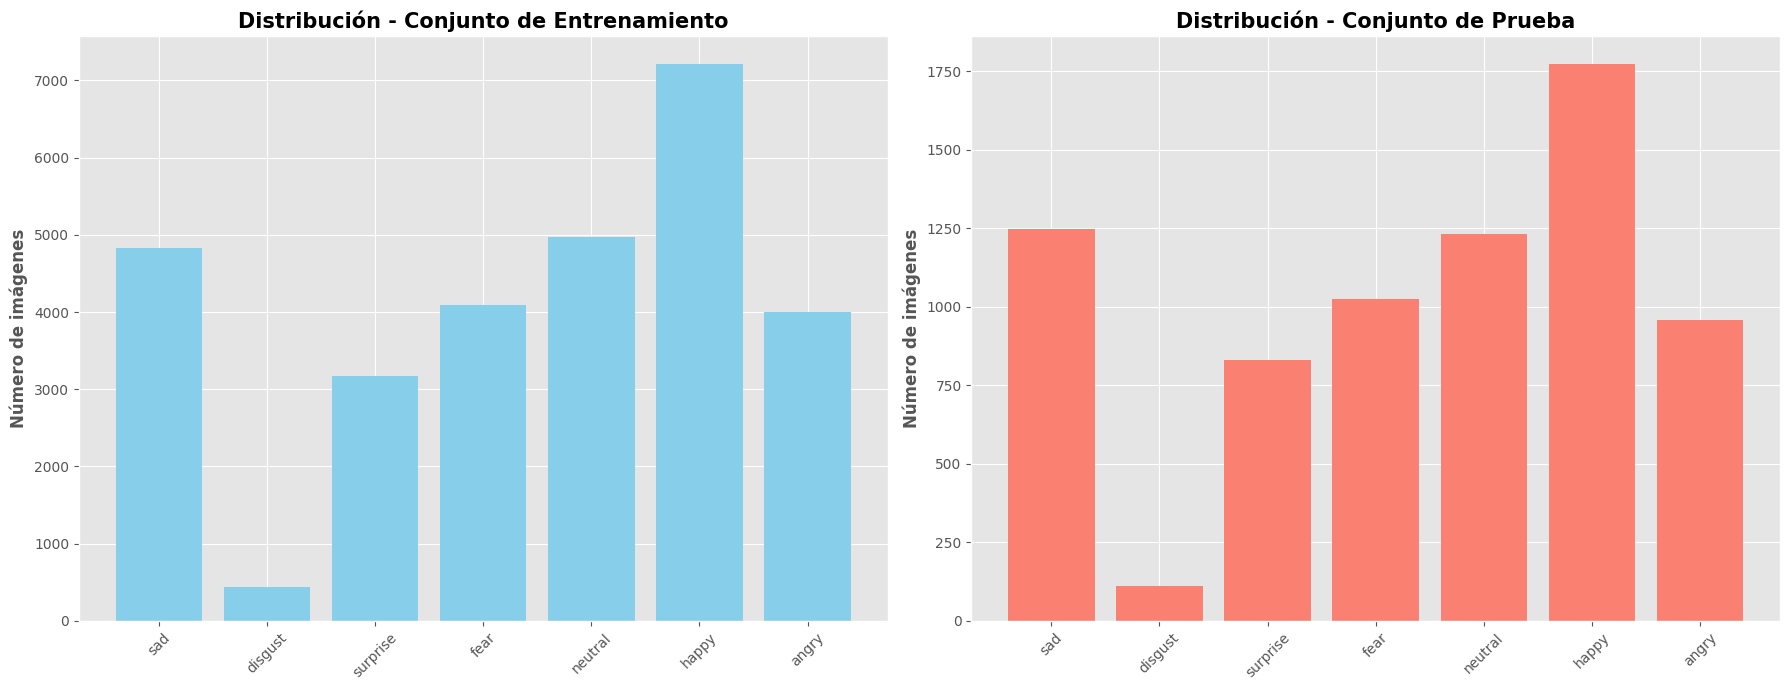

In [4]:
# --- Explicación: Visualización del balance de clases ---
# Se crean gráficos de barras para mostrar visualmente la distribución de imágenes
# por emoción, lo que permite identificar desbalances de forma intuitiva.

# Se crea una figura con dos subplots, uno para entrenamiento y otro para prueba.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfica para el conjunto de entrenamiento.
ax1.bar(train_distribution.keys(), train_distribution.values(), color='skyblue')
ax1.set_title('Distribución - Conjunto de Entrenamiento', fontsize=15, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Número de imágenes', fontweight='bold')

# Gráfica para el conjunto de prueba.
ax2.bar(test_distribution.keys(), test_distribution.values(), color='salmon')
ax2.set_title('Distribución - Conjunto de Prueba', fontsize=15, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Número de imágenes', fontweight='bold')

# Se ajusta el diseño para que no haya superposiciones y se muestra el gráfico.
plt.tight_layout()
plt.show()

### **Configuración de Parámetros y Generadores de Datos**

Esta celda es fundamental para el preprocesamiento de datos. Se definen parámetros clave como el tamaño de la imagen y el tamaño del lote (`BATCH_SIZE`). Luego, se utiliza `ImageDataGenerator` de Keras para dos propósitos:

####  **Normalización**
Se reescalan los valores de los píxeles de las imágenes del rango [0, 255] al rango [0, 1]. Esto es estándar para que el modelo converja más rápido.

####  **Aumento de Datos (Data Augmentation)**
Para el conjunto de entrenamiento, se aplican transformaciones aleatorias a las imágenes (rotaciones, desplazamientos, zoom, etc.). Esto crea versiones ligeramente modificadas de las imágenes existentes, lo que **aumenta artificialmente el tamaño del dataset** y ayuda al modelo a **generalizar mejor**, reduciendo el riesgo de sobreajuste (`overfitting`).

Finalmente, se crean los `generators` (`train`, `validation`, `test`), que cargarán los datos en lotes desde los directorios, aplicando las transformaciones definidas.

In [33]:
# --- Explicación: Preparación de datos para el modelo ---
# Se definen los hiperparámetros y se configuran los generadores de datos.

# --- Parámetros Globales ---
IMG_SIZE = 48      # Las imágenes se redimensionarán a 48x48 píxeles.
BATCH_SIZE = 64    # El modelo se entrenará con lotes de 64 imágenes a la vez.
NUM_CLASSES = 7    # Corresponde a las 7 emociones del dataset.
EPOCHS = 40       # Número máximo de épocas de entrenamiento (EarlyStopping lo ajustará).

# --- Aumento de Datos (Data Augmentation) ---
# Se crea un generador para los datos de entrenamiento que aplica transformaciones
# aleatorias para hacer el modelo más robusto y evitar el sobreajuste.
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normaliza los píxeles a un rango de [0, 1].
    rotation_range=15,              # Rota la imagen aleatoriamente hasta 15 grados.
    width_shift_range=0.1,          # Desplaza la imagen horizontalmente.
    height_shift_range=0.1,         # Desplaza la imagen verticalmente.
    shear_range=0.1,                # Aplica un cizallamiento.
    zoom_range=0.1,                 # Aplica un zoom aleatorio.
    horizontal_flip=True,           # Invierte la imagen horizontalmente.
    fill_mode='nearest'             # Rellena los nuevos píxeles con el valor más cercano.
)

# Se crea un generador para los datos de prueba y validación, que solo normaliza los datos.
# No se aplica aumento de datos aquí para obtener una evaluación consistente.
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Creación de los Generadores ---
# Se utiliza 'flow_from_directory' para leer las imágenes directamente desde las carpetas.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',           # Las imágenes se procesarán en rgb.
    batch_size=BATCH_SIZE,
    class_mode='categorical',         # Para clasificación multiclase.
    shuffle=True                      # Mezcla los datos en cada época.
)

# El generador de validación se crea a partir del mismo directorio de prueba.
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                     # No es necesario mezclar los datos de validación.
)

# Se obtiene y muestra el mapeo de las clases (emociones) a los índices numéricos.
class_names = list(train_generator.class_indices.keys())
print("\n🏷️ Etiquetas de clase encontradas:", class_names)

Found 28711 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

🏷️ Etiquetas de clase encontradas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### **Visualización de Muestras del Dataset**
Esta celda visualiza muestras aleatorias del dataset con sus etiquetas correspondientes, permitiendo verificar que los datos se han cargado correctamente.

Muestras del conjunto de entrenamiento:


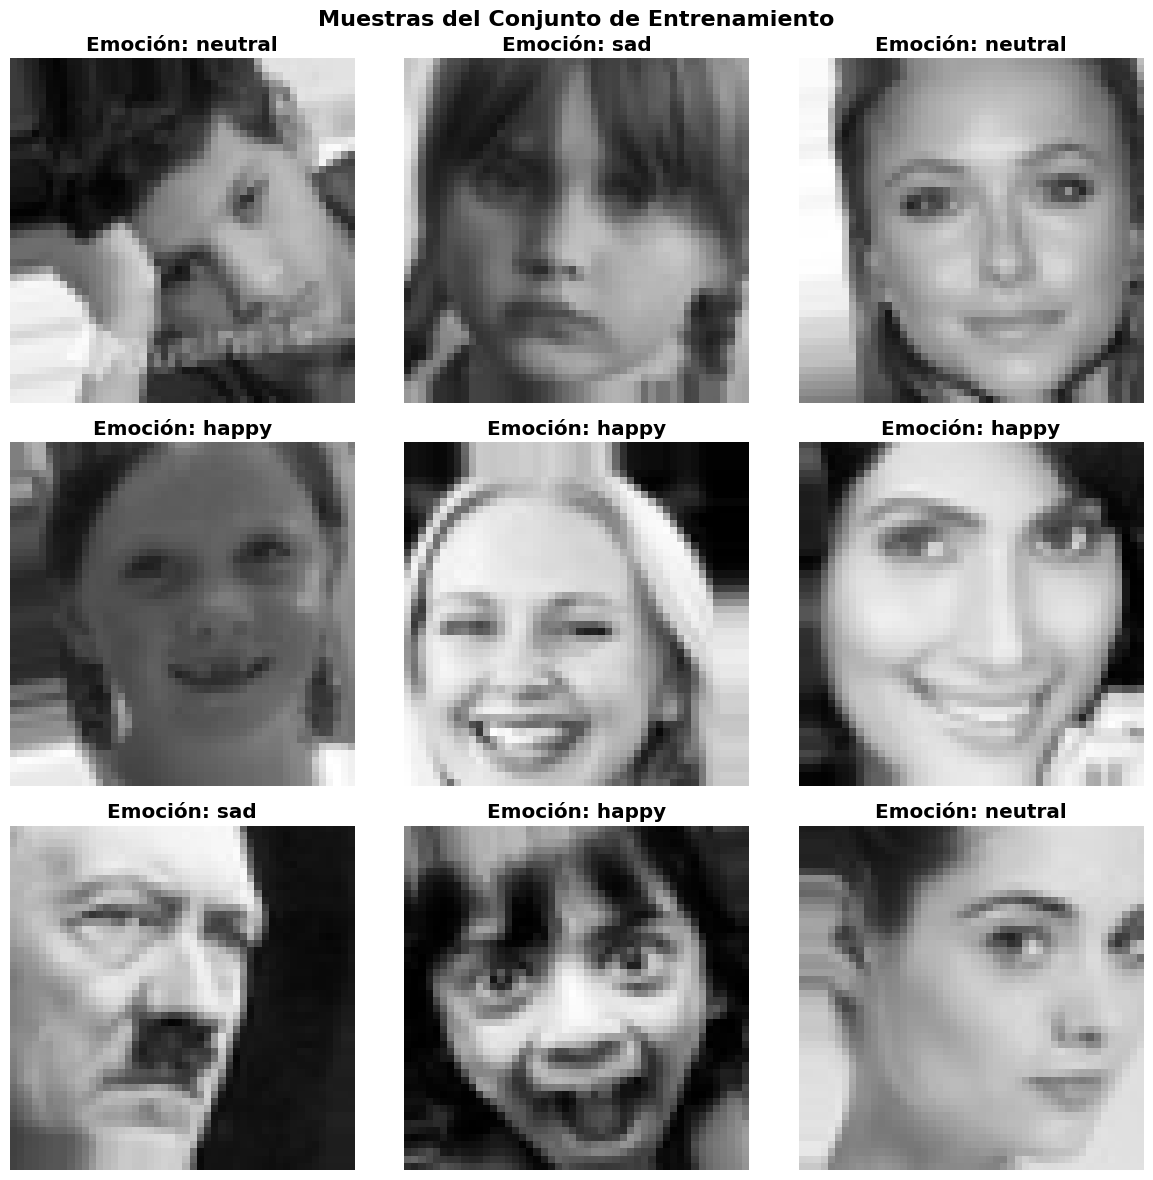


🖼️ Muestras del conjunto de validación:


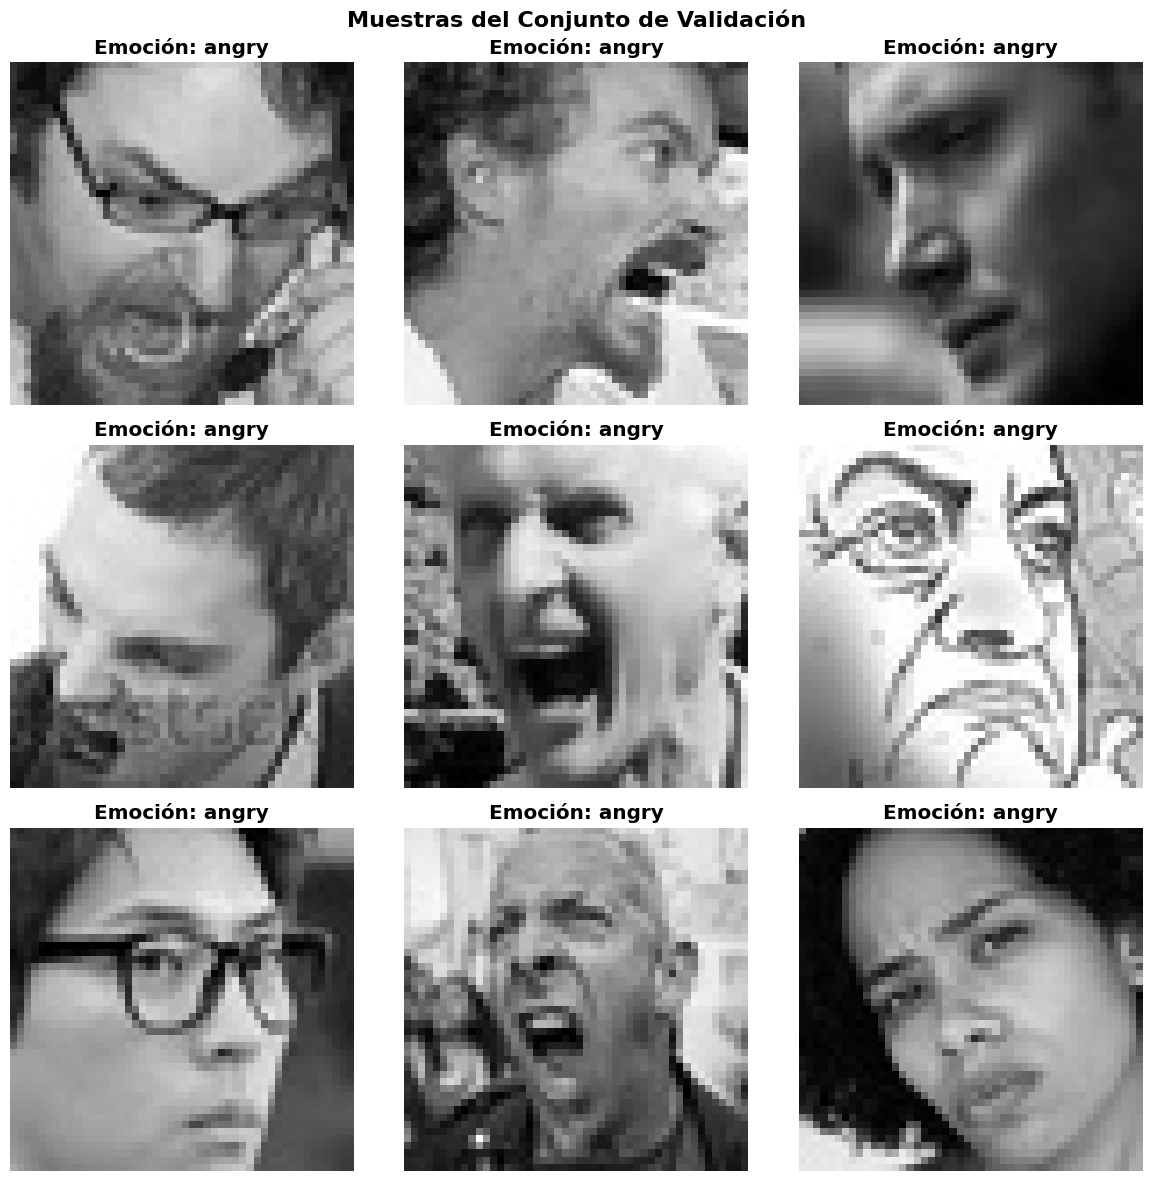

In [34]:
# Función para visualizar muestras del dataset
def visualize_samples(generator, num_samples=9, title="Muestras del Dataset"):
    # Se obtiene un lote de imágenes y etiquetas del generador.
    images, labels = next(generator)

    # Se crea la figura para mostrar las imágenes.
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(num_samples):
        # --- LÍNEA MODIFICADA ---
        # Se elimina .reshape(...) porque la imagen ya tiene la forma correcta (48, 48, 3).
        # Se elimina cmap='gray' para que matplotlib interprete la imagen como RGB.
        axes[i].imshow(images[i])

        # Se obtiene la etiqueta de la emoción correspondiente.
        true_label = class_names[np.argmax(labels[i])]
        axes[i].set_title(f"Emoción: {true_label}", fontweight='bold')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualizar muestras de entrenamiento
print("Muestras del conjunto de entrenamiento:")
visualize_samples(train_generator, title="Muestras del Conjunto de Entrenamiento")

# --- Visualizar muestras del conjunto de validación ---
# Se usan los datos de prueba, que en nuestro caso actúan como conjunto de validación.
print("\n🖼️ Muestras del conjunto de validación:")

# Se reinicia el generador para asegurar que se visualicen las primeras imágenes.
validation_generator.reset()

# Se llama a la función de visualización con el generador correcto.
visualize_samples(validation_generator, title="Muestras del Conjunto de Validación")

### **Cálculo de Pesos** (hay más fotos con emoción happy)**
Esa celda de código implementa una técnica crucial para lograr un entrenamiento más justo y equilibrado. Su objetivo es forzar al modelo a prestar la misma atención a todas las emociones, especialmente a aquellas que tienen muy pocas imágenes en el dataset. Lo hace asignando un "peso" o "importancia" a cada clase para nivelar el campo de juego.
el dataset FER2013 está desbalanceado: hay muchas más imágenes de "happy" que de otras emociones como "sad" o "disgust". Sin una corrección, el modelo se entrena en un entorno injusto. Entonces el modelo se vuelve un experto en "happy" porque es lo que más ve, y no aprende bien a distinguir las otras emociones.

In [35]:
# --- Celda Nueva: Calcular Pesos de Clase para Combatir el Desbalance ---
from sklearn.utils import class_weight
import numpy as np

# Se obtienen las etiquetas de todas las imágenes de entrenamiento.
# El generador debe estar sin shuffle para que las clases estén en orden.
train_generator.shuffle = False
class_labels = train_generator.classes
train_generator.shuffle = True # Se reactiva el shuffle para el entrenamiento

# Se calculan los pesos de clase. Las clases con menos muestras tendrán un peso mayor.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Se convierte a un diccionario que Keras pueda usar.
class_weights_dict = dict(enumerate(class_weights))

print("Pesos calculados para cada clase (0=angry, 1=disgust, etc.):")
print(class_weights_dict)

Pesos calculados para cada clase (0=angry, 1=disgust, etc.):
{0: np.float64(1.026676202395852), 1: np.float64(9.407273918741808), 2: np.float64(1.0011157990167021), 3: np.float64(0.5684783684783685), 4: np.float64(0.8257643302942276), 5: np.float64(0.8491866311742088), 6: np.float64(1.293463080596477)}


### **Configuración de Parámetros y Generadores de Datos**
Esta celda es fundamental para el preprocesamiento de datos. Se definen parámetros clave como el tamaño de la imagen y el tamaño del lote (BATCH_SIZE). Luego, se utiliza ImageDataGenerator de Keras para dos propósitos:

Normalización: Se reescalan los valores de los píxeles de las imágenes del rango [0, 255] al rango [0, 1]. Esto es estándar para que el modelo converja más rápido.

Aumento de Datos (Data Augmentation): Para el conjunto de entrenamiento, se aplican transformaciones aleatorias a las imágenes (rotaciones, desplazamientos, zoom, etc.). Esto crea versiones ligeramente modificadas de las imágenes existentes, lo que aumenta artificialmente el tamaño del dataset y ayuda al modelo a generalizar mejor, reduciendo el riesgo de sobreajuste (overfitting).

Finalmente, se crean los generators (train, validation, test), que cargarán los datos en lotes desde los directorios, aplicando las transformaciones definidas.

In [36]:
# --- Explicación: Preparación de datos para el modelo ---
# Se definen los hiperparámetros y se configuran los generadores de datos.

# --- Parámetros Globales ---
IMG_SIZE = 48      # Las imágenes se redimensionarán a 48x48 píxeles.
BATCH_SIZE = 64    # El modelo se entrenará con lotes de 64 imágenes a la vez.
NUM_CLASSES = 7    # Corresponde a las 7 emociones del dataset.
EPOCHS = 80       # Número máximo de épocas de entrenamiento (EarlyStopping lo ajustará).

# --- Aumento de Datos (Data Augmentation) ---
# Se crea un generador para los datos de entrenamiento que aplica transformaciones
# aleatorias para hacer el modelo más robusto y evitar el sobreajuste.
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normaliza los píxeles a un rango de [0, 1].
    rotation_range=15,              # Rota la imagen aleatoriamente hasta 15 grados.
    width_shift_range=0.1,          # Desplaza la imagen horizontalmente.
    height_shift_range=0.1,         # Desplaza la imagen verticalmente.
    shear_range=0.1,                # Aplica un cizallamiento.
    zoom_range=0.1,                 # Aplica un zoom aleatorio.
    horizontal_flip=True,           # Invierte la imagen horizontalmente.
    fill_mode='nearest'             # Rellena los nuevos píxeles con el valor más cercano.
)

# Se crea un generador para los datos de prueba y validación, que solo normaliza los datos.
# No se aplica aumento de datos aquí para obtener una evaluación consistente.
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Creación de los Generadores ---
# Se utiliza 'flow_from_directory' para leer las imágenes directamente desde las carpetas.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',           # Las imágenes se procesarán en escala de grises.
    batch_size=BATCH_SIZE,
    class_mode='categorical',         # Para clasificación multiclase.
    shuffle=True                      # Mezcla los datos en cada época.
)

# El generador de validación se crea a partir del mismo directorio de prueba.
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',           # Las imágenes se procesarán en escala de grises.
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                     # No es necesario mezclar los datos de validación.
)

# Se obtiene y muestra el mapeo de las clases (emociones) a los índices numéricos.
class_names = list(train_generator.class_indices.keys())
print("\n🏷️ Etiquetas de clase encontradas:", class_names)

Found 28711 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

🏷️ Etiquetas de clase encontradas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### **Creación del Modelo de Red Neuronal Convolucional (CNN)**

Esta celda implementa una técnica avanzada y eficiente llamada Aprendizaje por Transferencia (Transfer Learning). El concepto fundamental es que, en lugar de construir y enseñar a una red neuronal desde cero (lo cual es lento y requiere muchísimos datos), se reutiliza el "conocimiento" de un modelo experto que ya fue entrenado previamente.

El proceso se puede entender en cuatro pasos clave:

Se Importa un Cerebro Experto: Se carga el modelo MobileNetV2, una red neuronal diseñada por Google que ya es experta en reconocer características visuales. Fue entrenada con el dataset ImageNet, que contiene millones de imágenes de 1,000 categorías distintas (perros, gatos, autos, etc.). Gracias a esto, MobileNetV2 ya posee un vasto "vocabulario visual" y sabe identificar bordes, texturas, formas y patrones complejos.

Se Preserva su Conocimiento (Congelación): Una vez cargado el modelo experto, sus capas se "congelan" (base_model.trainable = False). Esto es crucial: significa que se bloquean sus millones de parámetros para que no se modifiquen durante nuestro entrenamiento. Se está tratando su conocimiento como una base sólida e inamovible. Este paso es el principal responsable del enorme ahorro en tiempo de cómputo.

Se Adapta a la Nueva Tarea: Al modelo MobileNetV2 se le quita su "cabeza" original (la capa que clasificaba entre 1,000 objetos) usando el argumento include_top=False. En su lugar, se le añade una nueva "cabeza" de clasificación, mucho más pequeña y simple, diseñada específicamente para nuestra tarea: clasificar las 7 emociones del dataset FER2013.

El Entrenamiento se Enfoca: Al final, cuando se inicia el entrenamiento, solo se ajustan los parámetros de la nueva y pequeña "cabeza" que se acaba de añadir. El cerebro experto congelado simplemente se usa para extraer características de alta calidad de las imágenes, las cuales son pasadas a la nueva cabeza para que esta aprenda a asociarlas con las emociones.

In [37]:
# --- Celda 6 Modificada: Creación del Modelo con Transfer Learning (MobileNetV2) ---

# Se importan las librerías y capas necesarias desde Keras.
# - MobileNetV2: Es la arquitectura del modelo pre-entrenado que se usará como base.
# - GlobalAveragePooling2D: Una capa que ayuda a reducir la dimensionalidad de los datos de forma eficiente.
# - Model: La clase que permite ensamblar el modelo final a partir de la base y las nuevas capas.
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# --- PASO 1: Cargar el modelo base pre-entrenado ---

# Se instancia el modelo MobileNetV2.
base_model = MobileNetV2(
    # 'imagenet' indica que se deben cargar los pesos (el "conocimiento")
    # obtenidos del entrenamiento con el dataset ImageNet.
    weights='imagenet',

    # 'include_top=False' significa que se excluye la última capa densa del modelo.
    # Se hace esto porque esa capa fue diseñada para clasificar 1000 objetos,
    # y nosotros necesitamos clasificar 7 emociones.
    include_top=False,

    # Se especifica la forma de las imágenes de entrada que recibirá el modelo.
    # Debe coincidir con el tamaño (IMG_SIZE) y los canales de color (3 para RGB)
    # definidos en los generadores de datos.
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# --- PASO 2: Congelar las capas del modelo base ---

# Se establece el atributo 'trainable' del modelo base como Falso.
# Esto "congela" todos sus parámetros, impidiendo que se actualicen
# durante el entrenamiento. Es el paso clave para la eficiencia.
base_model.trainable = False

# --- PASO 3: Añadir las nuevas capas de clasificación ---

# Se toma la salida del modelo base. Esta salida es un mapa de características
# de alta calidad extraídas de la imagen de entrada.
x = base_model.output

# Se aplica una capa de GlobalAveragePooling2D. Esta capa calcula el promedio
# de todos los valores en el mapa de características, convirtiéndolo en un
# único vector. Es una forma moderna y eficiente de preparar los datos para la clasificación.
x = GlobalAveragePooling2D()(x)

# Se añade una capa de Dropout. Esta técnica de regularización "apaga"
# aleatoriamente el 50% de las neuronas durante el entrenamiento para
# ayudar a prevenir el sobreajuste.
x = Dropout(0.5)(x)

# Se añade la capa de salida final. Es una capa Densa con un número de neuronas
# igual al número de clases (NUM_CLASSES = 7). La activación 'softmax' asegura
# que la salida sea una distribución de probabilidad, donde la suma de las
# probabilidades de todas las emociones es 1.
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# --- PASO 4: Ensamblar y compilar el modelo final ---

# Se crea el modelo final especificando cuál es su entrada (la del modelo base)
# y cuál es su salida (la capa de predicciones que se acaba de crear).
model = Model(inputs=base_model.input, outputs=predictions)

# Se compila el modelo, configurando el optimizador, la función de pérdida
# y las métricas que se monitorearán durante el entrenamiento. Este paso
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Se imprime un resumen de la arquitectura del modelo.
# Es importante notar aquí la drástica reducción en el número de "Trainable params"
# en comparación con el modelo construido desde cero.
model.summary()

/tmp/ipython-input-1128904954.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Este resultado es excelente, Es exactamente lo que se busca con la técnica de Transfer Learning y la razón principal por la que la implementamos.

Que la cantidad de parámetros entrenables sea tan pequeña es una muy buena noticia, especialmente porque se está entrenando en una CPU.

**¿Por Qué Este Resultado es Excelente?**
Los números que muestra usando la analogía del "cerebro experto":

Non-trainable params: 2,257,984 (8.61 MB)

🧠 Esto es el "cerebro congelado" de MobileNetV2. Representa todo el conocimiento experto sobre cómo interpretar imágenes que ya aprendió el modelo. Se está reutilizando gratis, sin el costo computacional de tener que entrenarlo.

Trainable params: 8,967 (35.03 KB)

👨‍🎓 Este es tu "pequeño aprendiz". Representa únicamente la pequeña "cabeza" clasificadora que se agregó al final. Esta es la única parte que la computadora necesita entrenar. El modelo solo tiene que aprender a ajustar estas ~9,000 "perillas" para conectar lo que ve el cerebro experto con las 7 emociones.

**La Conclusión Clave**
Cada época de entrenamiento será drásticamente más rápida. Se está forzando al modelo a hacer un trabajo computacionalmente muy ligero (entrenar 9k parámetros) mientras aprovecha todo el conocimiento pesado de un modelo experto (los 2.2M de parámetros congelados).

En resumen: es la definición de entrenar de forma inteligente y eficiente, y es la solución perfecta para la limitación de no poder usar GPU.

In [38]:
# --- Calcular Pesos de Clase para Combatir el Desbalance ---
from sklearn.utils import class_weight
import numpy as np

# Se obtienen las etiquetas de todas las imágenes de entrenamiento.
# El generador debe estar sin shuffle para que las clases estén en orden.
train_generator.shuffle = False
class_labels = train_generator.classes
train_generator.shuffle = True # Se reactiva el shuffle para el entrenamiento

# Se calculan los pesos de clase. Las clases con menos muestras tendrán un peso mayor.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Se convierte a un diccionario que Keras pueda usar.
class_weights_dict = dict(enumerate(class_weights))

print("Pesos calculados para cada clase (0=angry, 1=disgust, etc.):")
print(class_weights_dict)

Pesos calculados para cada clase (0=angry, 1=disgust, etc.):
{0: np.float64(1.026676202395852), 1: np.float64(9.407273918741808), 2: np.float64(1.0011157990167021), 3: np.float64(0.5684783684783685), 4: np.float64(0.8257643302942276), 5: np.float64(0.8491866311742088), 6: np.float64(1.293463080596477)}


### **Configuración de Callbacks y Entrenamiento del Modelo**

Esta celda inicia el proceso de entrenamiento. Antes de empezar, se configuran `callbacks`, que son funciones que se ejecutan en diferentes puntos del entrenamiento para mejorar el proceso:

  - **`ModelCheckpoint`:** Guarda automáticamente la mejor versión del modelo (basado en la precisión de validación) en un archivo. Esto asegura que, sin importar si el modelo empeora al final, siempre se conserve la versión con mejor rendimiento.
  - **`EarlyStopping`:** Monitorea la pérdida de validación y detiene el entrenamiento si no mejora después de un número determinado de épocas (`patience`). Esto evita el sobreajuste y ahorra tiempo computacional.
  - **`ReduceLROnPlateau`:** Reduce la tasa de aprendizaje (`learning rate`) si el modelo se estanca. Disminuir la tasa de aprendizaje puede ayudar al modelo a encontrar un mínimo mejor en la función de pérdida.

Luego, se llama a la función `model.fit()` para entrenar el modelo con los datos de entrenamiento y validación.

In [39]:
# --- Explicación: Definición de callbacks para un entrenamiento inteligente ---
# Los callbacks son herramientas que monitorean el entrenamiento y toman acciones
# para mejorar el proceso y el resultado final.

# 1. ModelCheckpoint: Guarda el mejor modelo encontrado hasta el momento.
checkpoint = ModelCheckpoint(
    'best_emotion_model.h5',         # Nombre del archivo donde se guardará el modelo.
    monitor='val_accuracy',          # Métrica a monitorear (precisión en validación).
    save_best_only=True,             # Solo guarda si el modelo mejora.
    mode='max',                      # El objetivo es maximizar la precisión.
    verbose=1
)

# 2. EarlyStopping: Detiene el entrenamiento si no hay mejora.
early_stopping = EarlyStopping(
    monitor='val_loss',              # Métrica a monitorear (pérdida en validación).
    patience=15,                     # Número de épocas a esperar sin mejora antes de parar.
    restore_best_weights=True,       # Restaura los pesos del mejor modelo al finalizar.
    verbose=1
)

# 3. ReduceLROnPlateau: Reduce la tasa de aprendizaje si el modelo se estanca.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                      # Factor por el cual se reducirá la tasa (lr = lr * factor).
    patience=5,                      # Épocas a esperar sin mejora antes de reducir la tasa.
    min_lr=0.00001,                  # Tasa de aprendizaje mínima.
    verbose=1
)

# --- Inicio del Entrenamiento ---
print("🚀 Iniciando el entrenamiento del modelo...")

# Se llama a la función 'fit' para entrenar el modelo.
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    # Se pasa la lista de callbacks definidos.
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights_dict #uso de pesos
)

print("\n✅ Entrenamiento completado.")

🚀 Iniciando el entrenamiento del modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.2033 - loss: 2.3474
Epoch 1: val_accuracy improved from -inf to 0.30914, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 119s 252ms/step - accuracy: 0.2033 - loss: 2.3471 - val_accuracy: 0.3091 - val_loss: 1.7426 - learning_rate: 0.0010
Epoch 2/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.2498 - loss: 1.9069
Epoch 2: val_accuracy improved from 0.30914 to 0.33895, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 106s 237ms/step - accuracy: 0.2498 - loss: 1.9069 - val_accuracy: 0.3390 - val_loss: 1.6791 - learning_rate: 0.0010
Epoch 3/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2549 - loss: 1.8781
Epoch 3: val_accuracy did not improve from 0.33895
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 238ms/step - accuracy: 0.2549 - loss: 1.8781 - val_accuracy: 0.3008 - val_loss: 1.7640 - learning_rate: 0.0010
Epoch 4/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2637 - loss: 1.8303
Epoch 4: val_accuracy did not improve from 0.33895
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 241ms/step - accuracy: 0.2637 - loss: 1.8303 - val_accuracy: 0.3345 - val_loss: 1.6921 - learning_rate: 0.0010
Epoch 5/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2596 - loss: 1.8473
Epoch 5: val_accuracy improved from 0.33895 to 0.35302, saving model to best_emotion_model.h5


449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 255ms/step - accuracy: 0.2596 - loss: 1.8473 - val_accuracy: 0.3530 - val_loss: 1.6541 - learning_rate: 0.0010
Epoch 6/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.2629 - loss: 1.8411
Epoch 6: val_accuracy did not improve from 0.35302
449/449 ━━━━━━━━━━━━━━━━━━━━ 105s 234ms/step - accuracy: 0.2628 - loss: 1.8411 - val_accuracy: 0.3115 - val_loss: 1.7278 - learning_rate: 0.0010
Epoch 7/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2735 - loss: 1.8339
Epoch 7: val_accuracy did not improve from 0.35302
449/449 ━━━━━━━━━━━━━━━━━━━━ 110s 245ms/step - accuracy: 0.2735 - loss: 1.8339 - val_accuracy: 0.3188 - val_loss: 1.7108 - learning_rate: 0.0010
Epoch 8/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2564 - loss: 1.8451
Epoch 8: val_accuracy did not improve from 0.35302
449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 246ms/step - accuracy: 0.2564 - loss: 1.8451 - val_accuracy: 0.3346 - val_loss: 1.7062 - learning_rate: 0.0010
Epo

449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 241ms/step - accuracy: 0.2875 - loss: 1.7698 - val_accuracy: 0.3557 - val_loss: 1.6494 - learning_rate: 2.5000e-04
Epoch 20/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2799 - loss: 1.7646
Epoch 20: val_accuracy did not improve from 0.35567
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 239ms/step - accuracy: 0.2799 - loss: 1.7646 - val_accuracy: 0.3518 - val_loss: 1.6605 - learning_rate: 2.5000e-04
Epoch 21/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.2826 - loss: 1.7366
Epoch 21: val_accuracy did not improve from 0.35567
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 239ms/step - accuracy: 0.2826 - loss: 1.7366 - val_accuracy: 0.3476 - val_loss: 1.6640 - learning_rate: 2.5000e-04
Epoch 22/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.2875 - loss: 1.7390
Epoch 22: val_accuracy did not improve from 0.35567
449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 0.2875 - loss: 1.7390 - val_accuracy: 0.3447 - val_loss: 1.6653 - learnin

449/449 ━━━━━━━━━━━━━━━━━━━━ 109s 242ms/step - accuracy: 0.2892 - loss: 1.7428 - val_accuracy: 0.3603 - val_loss: 1.6470 - learning_rate: 2.5000e-04
Epoch 24/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.2998 - loss: 1.7192
Epoch 24: val_accuracy did not improve from 0.36027
449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 248ms/step - accuracy: 0.2998 - loss: 1.7193 - val_accuracy: 0.3399 - val_loss: 1.6788 - learning_rate: 2.5000e-04
Epoch 25/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.2856 - loss: 1.7409
Epoch 25: val_accuracy did not improve from 0.36027
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2857 - loss: 1.7409 - val_accuracy: 0.3573 - val_loss: 1.6531 - learning_rate: 2.5000e-04
Epoch 26/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2901 - loss: 1.7397
Epoch 26: val_accuracy did not improve from 0.36027
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 240ms/step - accuracy: 0.2901 - loss: 1.7397 - val_accuracy: 0.3430 - val_loss: 1.6753 - learnin

449/449 ━━━━━━━━━━━━━━━━━━━━ 110s 245ms/step - accuracy: 0.2896 - loss: 1.7303 - val_accuracy: 0.3632 - val_loss: 1.6527 - learning_rate: 6.2500e-05
Epoch 37/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.2926 - loss: 1.7066
Epoch 37: val_accuracy did not improve from 0.36319
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2926 - loss: 1.7067 - val_accuracy: 0.3454 - val_loss: 1.6743 - learning_rate: 6.2500e-05
Epoch 38/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2870 - loss: 1.7253
Epoch 38: val_accuracy did not improve from 0.36319

Epoch 38: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 237ms/step - accuracy: 0.2870 - loss: 1.7253 - val_accuracy: 0.3561 - val_loss: 1.6611 - learning_rate: 6.2500e-05
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 23.

✅ Entrenamiento completado.


### **Evaluación y Visualización de Resultados del Entrenamiento**

Una vez finalizado el entrenamiento, es crucial evaluar su rendimiento.

####  **Evaluación en Test:**
Se carga el mejor modelo guardado por `ModelCheckpoint` y se evalúa en el conjunto de prueba (`test_generator`), que el modelo nunca ha visto. Esto proporciona una medida objetiva de qué tan bien generaliza el modelo a nuevos datos.

####  **Visualización del Historial:**
Se grafican las curvas de precisión y pérdida tanto para el conjunto de entrenamiento como para el de validación a lo largo de las épocas. Estos gráficos son herramientas de diagnóstico muy potentes:
  - Si la precisión de entrenamiento sigue subiendo mientras que la de validación se estanca o baja, es un claro signo de **sobreajuste**.
  - Si ambas métricas son bajas, puede ser un signo de **subajuste** (el modelo es demasiado simple).
  - Idealmente, ambas curvas deberían converger.

<!-- end list -->

🔍 Cargando el mejor modelo guardado...



🧪 Evaluando el modelo en el conjunto de prueba...
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.3054 - loss: 1.7191
------------------------------
🎯 Precisión final en prueba: 0.3632 (36.32%)
📉 Pérdida final en prueba: 1.6527
------------------------------


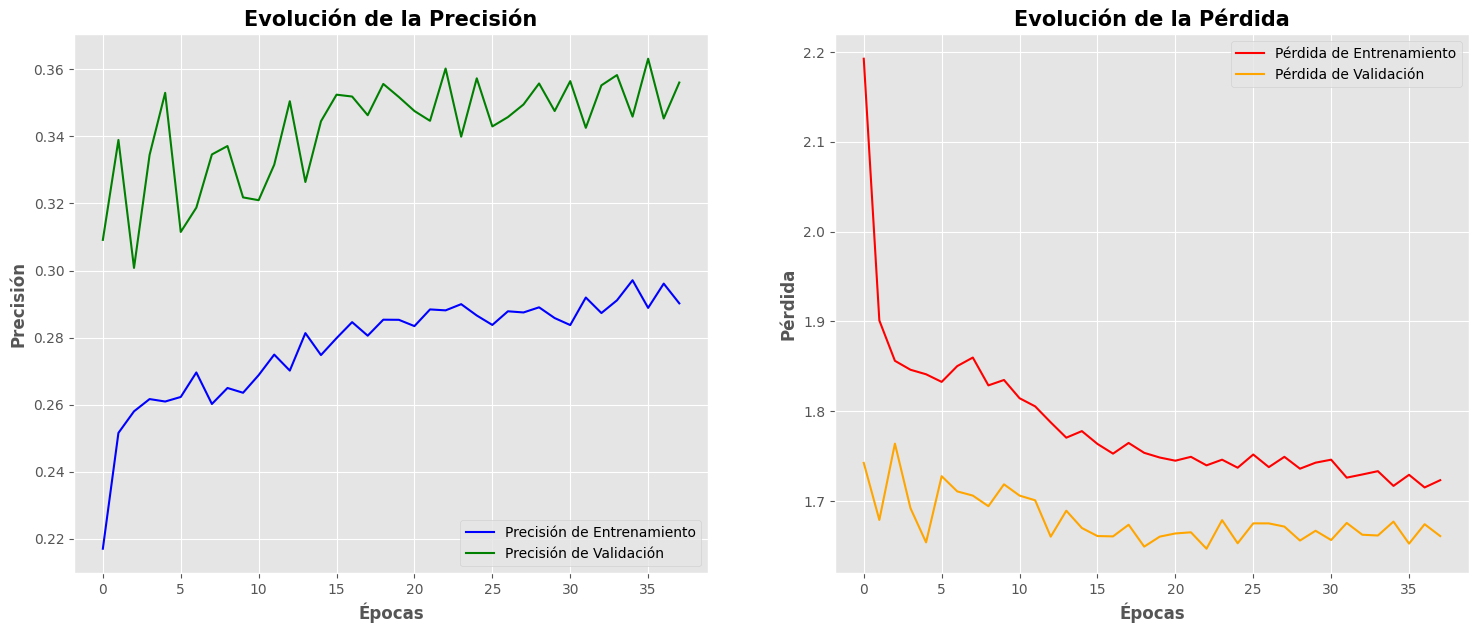

In [40]:
# --- Explicación: Análisis del rendimiento del modelo ---
# Se carga el mejor modelo guardado y se visualiza el historial de entrenamiento
# para diagnosticar su comportamiento (ej. sobreajuste).

# Se carga el mejor modelo que fue guardado por el callback ModelCheckpoint.
print("🔍 Cargando el mejor modelo guardado...")
best_model = load_model('best_emotion_model.h5')

# Se evalúa el rendimiento del mejor modelo en el conjunto de prueba.
print("\n🧪 Evaluando el modelo en el conjunto de prueba...")
test_loss, test_accuracy = best_model.evaluate(validation_generator, verbose=1)
print("-" * 30)
print(f"🎯 Precisión final en prueba: {test_accuracy:.4f} ({(test_accuracy * 100):.2f}%)")
print(f"📉 Pérdida final en prueba: {test_loss:.4f}")
print("-" * 30)

# --- Gráficos de Precisión y Pérdida ---
# Se extraen los datos del historial de entrenamiento.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Se crea una figura para mostrar ambos gráficos.
plt.figure(figsize=(18, 7))

# Gráfico de Precisión.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento', color='blue')
plt.plot(epochs_range, val_acc, label='Precisión de Validación', color='green')
plt.legend(loc='lower right')
plt.title('Evolución de la Precisión', fontsize=15, fontweight='bold')
plt.xlabel('Épocas', fontweight='bold')
plt.ylabel('Precisión', fontweight='bold')

# Gráfico de Pérdida.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento', color='red')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación', color='orange')
plt.legend(loc='upper right')
plt.title('Evolución de la Pérdida', fontsize=15, fontweight='bold')
plt.xlabel('Épocas', fontweight='bold')
plt.ylabel('Pérdida', fontweight='bold')

# Se muestra la figura con los gráficos.
plt.show()

La Precisión General Aumenta: En el gráfico de la izquierda, tanto la línea verde (entrenamiento) como la azul (validación) tienen una tendencia general hacia arriba. Esto es excelente, ya que significa que el modelo está aprendiendo y mejorando su capacidad para clasificar las emociones correctamente con cada época.

La Pérdida General Disminuye: En el gráfico de la derecha, ambas curvas de pérdida (error) tienden a bajar. La línea roja (entrenamiento) muestra una caída constante, lo que indica que el modelo se ajusta bien a los datos que ve. La línea naranja (validación), aunque ruidosa, también se mantiene baja y no sube, lo que es una buena señal.

El Aprendizaje es Estable: No hay caídas repentinas ni un colapso en la precisión de validación. El modelo está generalizando de manera consistente a los datos nuevos, aunque no tan bien como a los datos de entrenamiento.

⚠️ Punto a Mejorar (El Sobreajuste)
El principal punto a observar es el sobreajuste o overfitting. Esto se evidencia por la brecha que existe entre las curvas de entrenamiento y validación.

En el Gráfico de Precisión: La línea verde (entrenamiento) está consistentemente por encima de la línea azul (validación). Esto significa que el modelo es significativamente mejor prediciendo las imágenes que ya ha visto durante el entrenamiento que prediciendo imágenes nuevas. Se está "memorizando" un poco los datos de entrenamiento.

En el Gráfico de Pérdida: Aunque la pérdida de validación no aumenta (lo cual sería una señal de alarma grave), se mantiene en una meseta mientras que la pérdida de entrenamiento sigue bajando. Esto confirma que al modelo le resulta más "fácil" clasificar los datos conocidos.

💡 Diagnóstico General y Siguientes Pasos
Diagnóstico: El modelo está funcionando como se esperaba. El sobreajuste que se observa es leve y está siendo controlado por las técnicas que ya usamos (como el Dropout y el Aumento de Datos).

Recomendaciones:

Continuar el Entrenamiento: Dado que la precisión de validación (línea azul) todavía tiene una ligera tendencia a subir y la pérdida de validación (línea naranja) no sube, deja que el modelo siga entrenando. Es muy probable que aún pueda mejorar. El callback de EarlyStopping se encargará de detenerlo automáticamente si deja de progresar.

El Valor de la Precisión: Una precisión del 35% puede parecer baja, pero para el dataset FER2013 (que es difícil y tiene 7 clases), obtener este resultado en solo 20 épocas con Transfer Learning es un comienzo muy sólido. El azar puro sería un 14% de precisión.

En conclusión, los resultados son positivos y el proceso va por buen camino. El siguiente paso es simplemente tener paciencia y dejar que el modelo continúe su entrenamiento.

### **Funciones para Preprocesamiento y Predicción**

Esta celda define funciones para preprocesar imágenes personalizadas y realizar predicciones de emociones con el modelo entrenado, preparando el sistema para la interfaz interactiva.

In [41]:
# Función para preprocesar imágenes personalizadas
def preprocess_custom_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    try:
        # Leer la imagen
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("No se pudo cargar la imagen")

        # Convertir a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Redimensionar
        resized_img = cv2.resize(gray, target_size)

        # Normalizar
        normalized_img = resized_img.astype('float32') / 255.0

        # Expandir dimensiones para que coincida con la entrada del modelo
        processed_img = np.expand_dims(normalized_img, axis=-1)  # Añadir dimensión de canal
        processed_img = np.expand_dims(processed_img, axis=0)    # Añadir dimensión de lote

        return processed_img, resized_img

    except Exception as e:
        print(f'Error al preprocesar la imagen: {e}')
        return None, None

# Función para predecir emociones
def predict_emotion(image_path, model):
    # Preprocesar la imagen
    processed_img, original_img = preprocess_custom_image(image_path)

    if processed_img is None:
        return None, None, None, None

    # Realizar predicción
    prediction = model.predict(processed_img, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    emotion = class_names[predicted_class]

    return emotion, confidence, original_img, prediction[0]

print("Funciones de predicción definidas correctamente.")

Funciones de predicción definidas correctamente.


### **Interfaz Interactiva para Probar con Imágenes Propias**

**Explicación Conceptual:**
El objetivo final del proyecto es utilizar el modelo entrenado en imágenes nuevas. Esta celda implementa una **interfaz interactiva** en Colab.

1.  **Subida de Archivo:** Utiliza el módulo `files` de Colab para permitir al usuario subir una imagen desde su computadora.
2.  **Preprocesamiento:** La imagen subida se procesa utilizando OpenCV (`cv2`) para asegurar que tenga el mismo formato que las imágenes de entrenamiento (48x48, escala de grises, normalizada).
3.  **Predicción:** El modelo (`best_model`) predice la emoción de la imagen preprocesada.
4.  **Visualización de Resultados:** Muestra la imagen original junto con la predicción del modelo y un gráfico de barras que detalla la distribución de probabilidad para cada una de las 7 emociones.
5.  **Bucle Interactivo:** El código está dentro de un bucle `while` que pregunta al usuario si desea analizar otra imagen, permitiendo realizar múltiples pruebas de forma consecutiva y cómoda.

<!-- end list -->

**Se guarda log de la predicción**


--- MENÚ PRINCIPAL DEL SISTEMA DE RECONOCIMIENTO DE EMOCIONES ---
1. Analizar una nueva imagen
2. Ver el registro de predicciones (log)
3. Eliminar el registro de predicciones (log)
4. Salir
Selecciona una opción (1-4): 1

⬆️ Por favor, sube una imagen para analizar la emoción:


Saving feliz.png to feliz.png

🖼️ Analizando la imagen: feliz.png
----------------------------------------


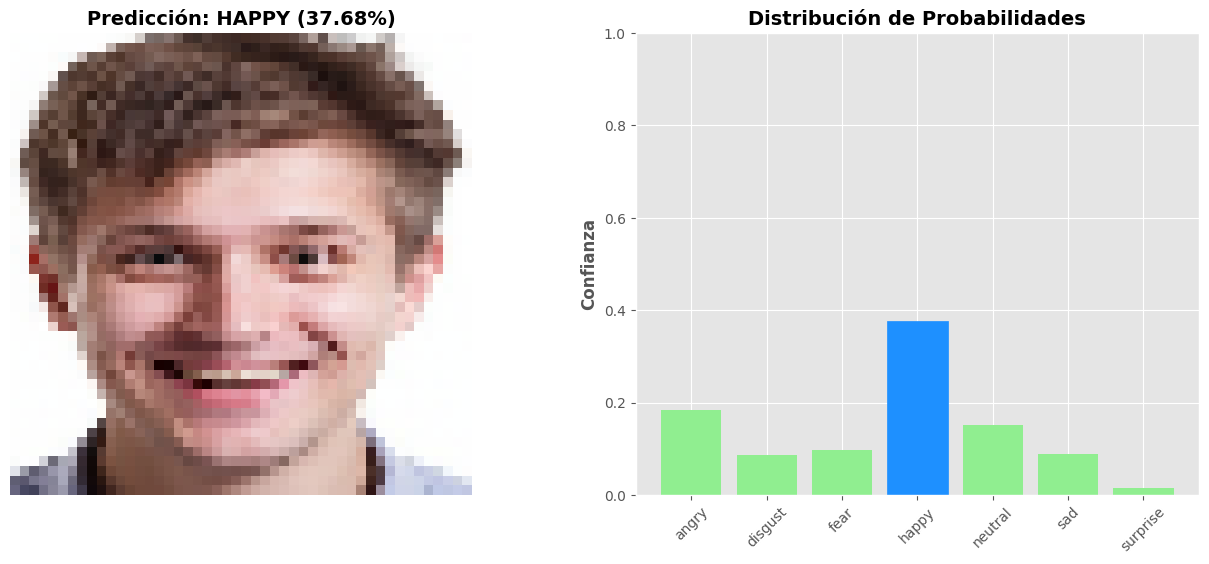


📋 RESULTADOS DETALLADOS DE LA PREDICCIÓN
- Angry     : 18.30%
- Disgust   : 8.70%
- Fear      : 9.71%
- Happy     : 37.68% ★ PREDICCIÓN ★
- Neutral   : 15.18%
- Sad       : 8.87%
- Surprise  : 1.57%
✅ Predicción guardada en: /content/drive/MyDrive/Colab Notebooks/PROYECTO_FER_2013/prediction_log.csv

--- MENÚ PRINCIPAL DEL SISTEMA DE RECONOCIMIENTO DE EMOCIONES ---
1. Analizar una nueva imagen
2. Ver el registro de predicciones (log)
3. Eliminar el registro de predicciones (log)
4. Salir
Selecciona una opción (1-4): 1

⬆️ Por favor, sube una imagen para analizar la emoción:


Saving bautista_enojado.png to bautista_enojado.png

🖼️ Analizando la imagen: bautista_enojado.png
----------------------------------------


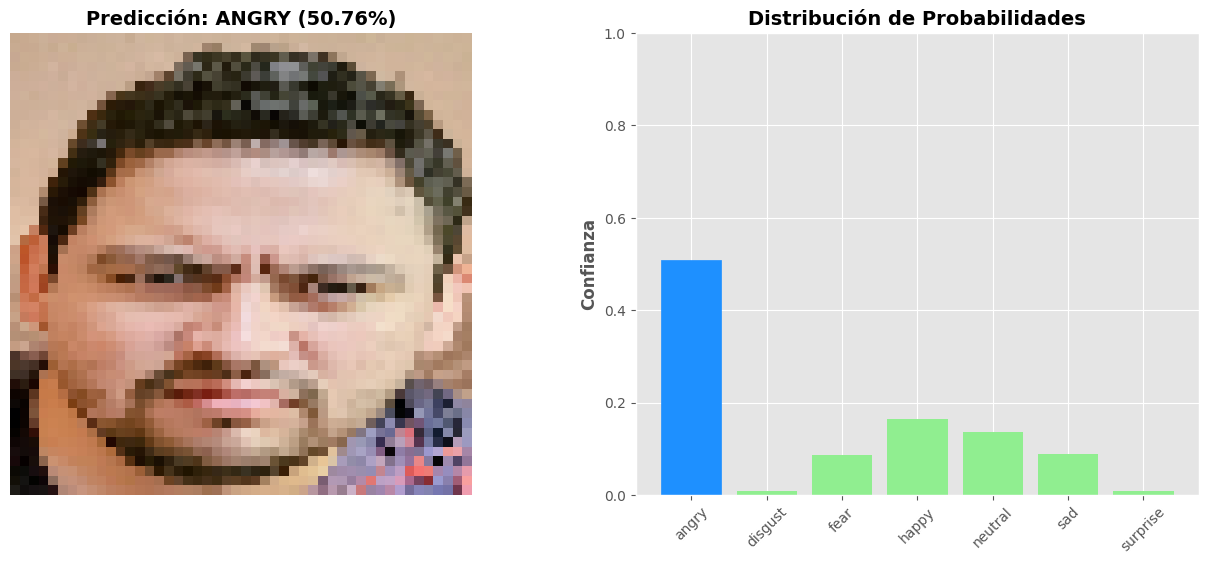


📋 RESULTADOS DETALLADOS DE LA PREDICCIÓN
- Angry     : 50.76% ★ PREDICCIÓN ★
- Disgust   : 0.92%
- Fear      : 8.55%
- Happy     : 16.38%
- Neutral   : 13.69%
- Sad       : 8.88%
- Surprise  : 0.84%
✅ Predicción guardada en: /content/drive/MyDrive/Colab Notebooks/PROYECTO_FER_2013/prediction_log.csv

--- MENÚ PRINCIPAL DEL SISTEMA DE RECONOCIMIENTO DE EMOCIONES ---
1. Analizar una nueva imagen
2. Ver el registro de predicciones (log)
3. Eliminar el registro de predicciones (log)
4. Salir
Selecciona una opción (1-4): 1

⬆️ Por favor, sube una imagen para analizar la emoción:


Saving wilsen.png to wilsen.png

🖼️ Analizando la imagen: wilsen.png
----------------------------------------


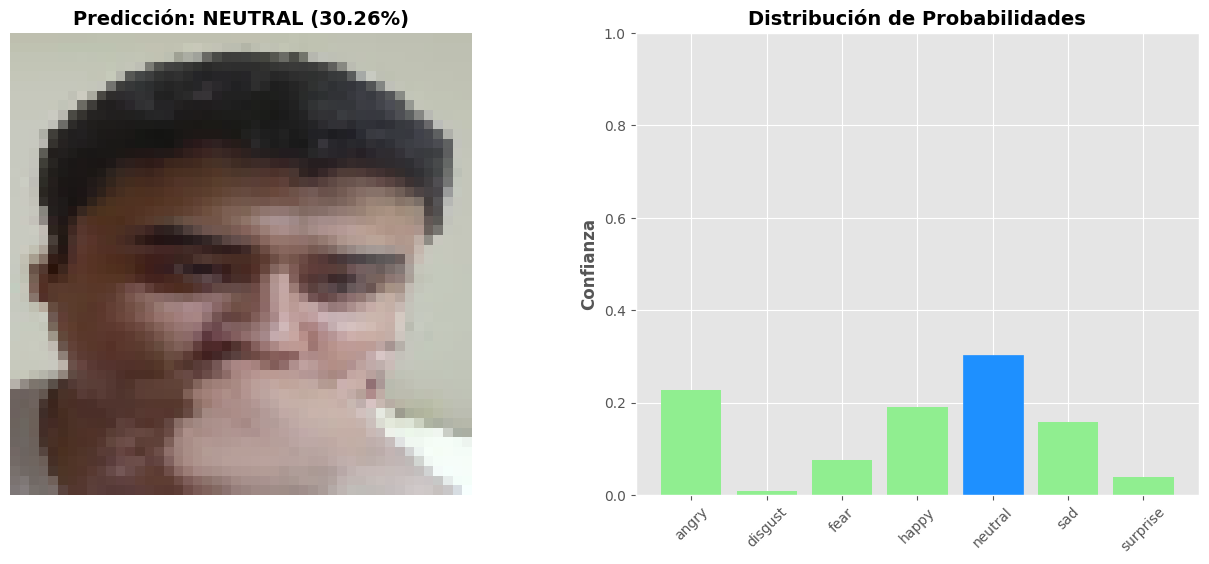


📋 RESULTADOS DETALLADOS DE LA PREDICCIÓN
- Angry     : 22.62%
- Disgust   : 0.79%
- Fear      : 7.64%
- Happy     : 18.95%
- Neutral   : 30.26% ★ PREDICCIÓN ★
- Sad       : 15.79%
- Surprise  : 3.95%
✅ Predicción guardada en: /content/drive/MyDrive/Colab Notebooks/PROYECTO_FER_2013/prediction_log.csv

--- MENÚ PRINCIPAL DEL SISTEMA DE RECONOCIMIENTO DE EMOCIONES ---
1. Analizar una nueva imagen
2. Ver el registro de predicciones (log)
3. Eliminar el registro de predicciones (log)
4. Salir
Selecciona una opción (1-4): 2

--- 📖 Mostrando Registro de Predicciones de '/content/drive/MyDrive/Colab Notebooks/PROYECTO_FER_2013/prediction_log.csv' ---


,Timestamp,Filename,Predicted Emotion,Confidence,All Probabilities
0,2025-09-13 18:11:30,asustado (1).jpg,surprise,29.59%,"0.197, 0.002, 0.179, 0.166, 0.071, 0.091, 0.296"
1,2025-09-13 18:30:40,feliz.png,happy,37.68%,"0.183, 0.087, 0.097, 0.377, 0.152, 0.089, 0.016"
2,2025-09-13 18:31:30,bautista_enojado.png,angry,50.76%,"0.508, 0.009, 0.085, 0.164, 0.137, 0.089, 0.008"
3,2025-09-13 18:32:03,wilsen.png,neutral,30.26%,"0.226, 0.008, 0.076, 0.189, 0.303, 0.158, 0.040"



--- MENÚ PRINCIPAL DEL SISTEMA DE RECONOCIMIENTO DE EMOCIONES ---
1. Analizar una nueva imagen
2. Ver el registro de predicciones (log)
3. Eliminar el registro de predicciones (log)
4. Salir


In [ ]:
# --- Se importan las librerías necesarias para el registro ---
import csv
from datetime import datetime
import os
import pandas as pd
from IPython.display import display

# --- Se define la ruta donde se guardará el archivo de log en tu Google Drive ---
# Asegúrate de que la ruta base coincida con la que usaste en las celdas anteriores.
log_path = "/content/drive/MyDrive/Colab Notebooks/PROYECTO_FER_2013/prediction_log.csv"


def save_prediction_to_log(filename, emotion, confidence, all_predictions):
    """
    Guarda los resultados de una predicción en el archivo CSV.
    Si el archivo no existe, crea uno nuevo con las cabeceras.
    """
    # Se obtiene la fecha y hora actual.
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Se prepara la fila de datos para guardar.
    log_data = [
        timestamp,
        filename,
        emotion,
        f"{confidence:.2%}",
        # Se guardan todas las probabilidades como un string para legibilidad.
        ", ".join([f"{p:.3f}" for p in all_predictions])
    ]

    try:
        # Se verifica si el archivo ya existe para decidir si se escribe la cabecera.
        file_exists = os.path.isfile(log_path)

        # Se abre el archivo en modo 'append' (añadir al final) para no borrar datos previos.
        with open(log_path, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)

            # Si el archivo no existía, se escribe la fila de cabeceras.
            if not file_exists:
                header = ['Timestamp', 'Filename', 'Predicted Emotion', 'Confidence', 'All Probabilities']
                writer.writerow(header)

            # Se escribe la nueva predicción.
            writer.writerow(log_data)

        print(f"✅ Predicción guardada en: {log_path}")

    except Exception as e:
        print(f"❌ Error al guardar el log: {e}")


def interactive_test_interface():
    """
    Función principal para subir, procesar y predecir una imagen.
    Ahora también llama a la función para guardar el log.
    """
    print("\n⬆️ Por favor, sube una imagen para analizar la emoción:")
    uploaded = files.upload()

    if not uploaded:
        print("No se seleccionó ningún archivo.")
        return

    filename = list(uploaded.keys())[0]
    print(f"\n🖼️ Analizando la imagen: {filename}")
    print("-" * 40)

    try:
        img_bgr = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
        normalized_img = resized_img / 255.0
        input_img = np.expand_dims(normalized_img, axis=0)

        predictions = best_model.predict(input_img, verbose=0)
        predicted_class_index = np.argmax(predictions[0])
        predicted_emotion = class_names[predicted_class_index]
        confidence = np.max(predictions[0])

        # --- Visualización de Resultados (sin cambios) ---
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(resized_img)
        plt.title(f'Predicción: {predicted_emotion.upper()} ({confidence:.2%})', fontsize=14, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        bars = plt.bar(class_names, predictions[0], color='lightgreen')
        bars[predicted_class_index].set_color('dodgerblue')
        plt.title('Distribución de Probabilidades', fontsize=14, fontweight='bold')
        plt.ylabel('Confianza', fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.show()

        print("\n" + "="*50)
        print("📋 RESULTADOS DETALLADOS DE LA PREDICCIÓN")
        print("="*50)
        for i, emotion in enumerate(class_names):
            marker = " ★ PREDICCIÓN ★" if i == predicted_class_index else ""
            print(f"- {emotion.capitalize():<10}: {predictions[0][i]:.2%}{marker}")

        # --- Se llama a la función para guardar el log ---
        save_prediction_to_log(filename, predicted_emotion, confidence, predictions[0])

    except Exception as e:
        print(f"❌ Ocurrió un error al procesar la imagen: {e}")
        print("Asegúrate de que el archivo subido sea una imagen válida.")


def view_log():
    """Muestra el contenido del log de predicciones usando pandas."""
    if os.path.isfile(log_path):
        print(f"\n--- 📖 Mostrando Registro de Predicciones de '{log_path}' ---")
        try:
            log_df = pd.read_csv(log_path)
            display(log_df)
        except Exception as e:
            print(f"❌ No se pudo leer el archivo de log: {e}")
    else:
        print("\nℹ️ No se ha encontrado ningún archivo de log. Realiza una predicción primero.")


def delete_log():
    """Elimina el archivo de log de predicciones previa confirmación."""
    if os.path.isfile(log_path):
        confirm = input(f"❓ ¿Estás seguro de que deseas eliminar el archivo de log '{log_path}'? Esta acción es irreversible. (s/n): ").lower()
        if confirm == 's':
            try:
                os.remove(log_path)
                print(f"\n✅ Archivo de log eliminado correctamente.")
            except Exception as e:
                print(f"\n❌ Error al eliminar el archivo: {e}")
        else:
            print("\nℹ️ Operación cancelada.")
    else:
        print("\nℹ️ No hay ningún archivo de log para eliminar.")


# --- Bucle de Ejecución con MENÚ INTERACTIVO ---
while True:
    print("\n" + "="*60)
    print("--- MENÚ PRINCIPAL DEL SISTEMA DE RECONOCIMIENTO DE EMOCIONES ---")
    print("1. Analizar una nueva imagen")
    print("2. Ver el registro de predicciones (log)")
    print("3. Eliminar el registro de predicciones (log)")
    print("4. Salir")
    print("="*60)

    choice = input("Selecciona una opción (1-4): ").strip()

    if choice == '1':
        interactive_test_interface()
    elif choice == '2':
        view_log()
    elif choice == '3':
        delete_log()
    elif choice == '4':
        print("\n👋 ¡Gracias por usar el sistema! Saliendo...")
        break
    else:
        print("\n❌ Opción no válida. Por favor, introduce un número del 1 al 4.")